In [1]:
import os
import cv2
import numpy as np
import skimage.io
from keras import models
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet')

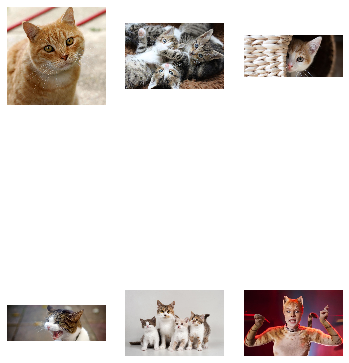

In [3]:
BASE_PATH = '/Users/gursharan/Desktop/'
cat_images = []
fig, axes = plt.subplots(2,3, figsize=(6,9))
for i in range(2):
    h = 0
    for cat in ['cat', 'cats', 'misc_cat']:
        file_path = os.path.join(BASE_PATH, cat + str(i+1) + '.jpg')
        img = skimage.io.imread(file_path)
        axis = axes[i][h]
        axis.axis('off')
        axis.imshow(img)
        h = h + 1

In [4]:
def show_heatmap(image_path):
    img = image.load_img(image_path, target_size=(224,224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0) #examples axis
    img = preprocess_input(img_tensor)
    
    plt.imshow(mpimg.imread(image_path))
    plt.show()
    
    orig_pred = model.predict(img);
    activation = np.argmax(orig_pred[0]);
    print('activation layer is : ', activation)
    pred = decode_predictions( orig_pred, top=3)[0]
    print(pred[0][1], 'with {}% probability'.format((pred[0][2]*1e4)//100))
    
    image_output = model.output[:, activation]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(image_output, last_conv_layer.output)[0]
    
    pooled_grads = K.mean(grads, axis=(0,1,2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    pooled_grads_value, conv_layer_output_value = iterate([img])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img_raw = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img_raw.shape[1],img_raw.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_final = heatmap * 0.4 + img_raw
    final_image_path = image_path[:-4]+'_heatmap.jpg';
    cv2.imwrite(final_image_path, img_final)
    
    plt.imshow(mpimg.imread(final_image_path))
    plt.show()

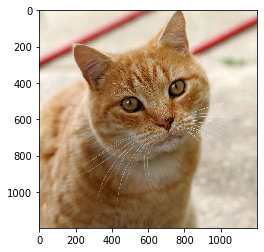

activation layer is :  282
tiger_cat with 41.0% probability


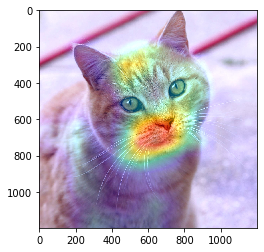

In [5]:
show_heatmap(os.path.join(BASE_PATH, 'cat1.jpg'))

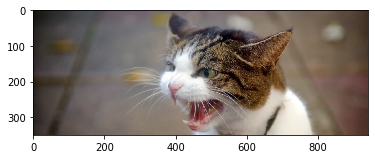

activation layer is :  281
tabby with 26.0% probability


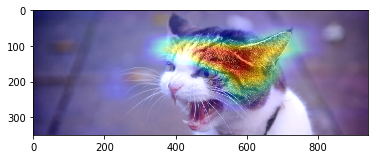

In [6]:
show_heatmap(os.path.join(BASE_PATH, 'cat2.jpg'))

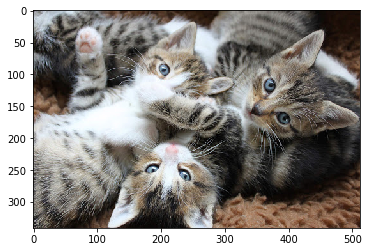

activation layer is :  281
tabby with 55.0% probability


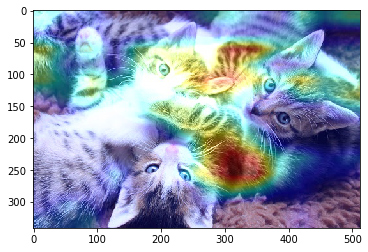

In [7]:
show_heatmap(os.path.join(BASE_PATH, 'cats1.jpg'))

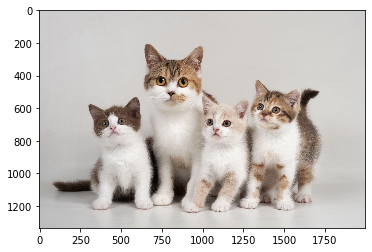

activation layer is :  285
Egyptian_cat with 38.0% probability


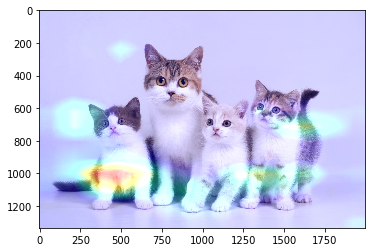

In [8]:
show_heatmap(os.path.join(BASE_PATH, 'cats2.jpg'))

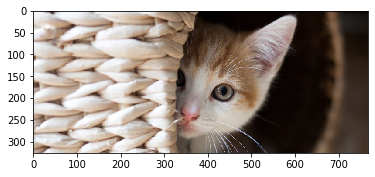

activation layer is :  987
corn with 64.0% probability


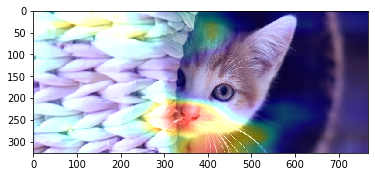

In [9]:
show_heatmap(os.path.join(BASE_PATH, 'misc_cat1.jpg'))

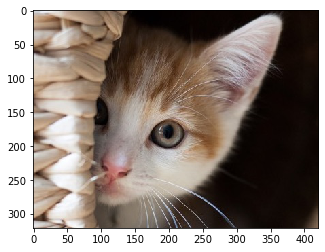

activation layer is :  285
Egyptian_cat with 26.0% probability


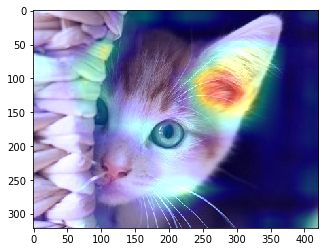

In [10]:
show_heatmap(os.path.join(BASE_PATH, 'crop_cat1.jpg'))

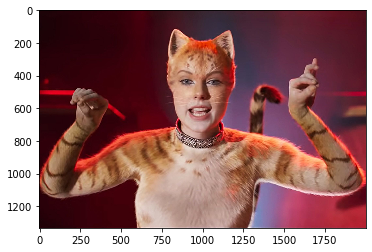

activation layer is :  285
Egyptian_cat with 46.0% probability


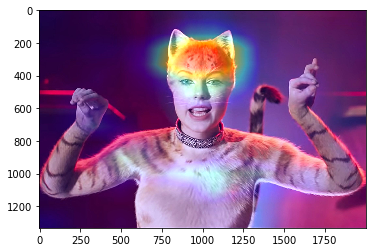

In [11]:
show_heatmap(os.path.join(BASE_PATH, 'misc_cat2.jpg'))

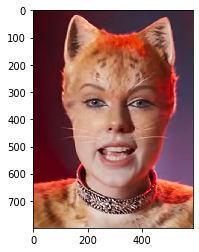

activation layer is :  285
Egyptian_cat with 71.0% probability


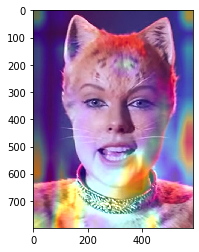

In [12]:
show_heatmap(os.path.join(BASE_PATH, 'misc_cat3.jpg'))